In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np 
import matplotlib.pyplot as plt 
import math,copy,time

## Attention

In [2]:
def ScaledDotProductAttention(Q,K,V,mask=None,drop=None):
    dim_k=K.shape[-1]
    scores=torch.matmul(Q,K.transpose(-2,-1))/np.sqrt(dim_k)
    if mask is not None:
        scores=torch.masked_fill(mask,-1e-9)
    attn=F.softmax(scores,dim=-1)
    if drop is not None:
        attn=drop(attn)
    context=torch.matmul(attn,V)
    return context,attn

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self,num_head=8,d_k=64,d_v=64,d_model=512,drop=0.1):
        super(MultiHeadAttention,self).__init__()
        self.is_attn=True

        self.num_head=num_head
        self.d_k=d_k
        self.d_v=d_v
        self.d_model=d_model

        self.Wq=nn.Linear(d_model,d_k*num_head)
        self.Wk=nn.Linear(d_model,d_k*num_head)
        self.Wv=nn.Linear(d_model,d_v*num_head)

        self.dropout=nn.Dropout(p=drop)
        self.project=nn.Linear(d_v*num_head,d_model)
    def forward(self,q,k,v,mask=None):
        b_szie=q.shape[0]
        #[b,l,d_k*num_head]
        Q=self.Wq(q)
        K=self.Wq(k)
        V=self.Wq(v)
        #[b,num_head,l,d_k]
        Q=Q.reshape(b_size,-1,self.num_head,self.d_k).transpose(1,2)
        K=K.reshape(b_size,-1,self.num_head,self.d_k).transpose(1,2)
        V=V.reshape(b_size,-1,self.num_head,self.d_v).transpose(1,2)

        if mask is not None:
            mask=mask.usqueeze(1).repeat(1,self.num_head,1,1)

        context,attn=ScaledDotProductAttention(Q,K,V,mask=mask,drop=self.dropout)
        context=context.transpose(1,2).reshape(b_szie,-1,self.num_head*self.d_v)

        return self.project(context),attn

In [4]:
class FFN(nn.Module):
    "Position-wise Feed-Forward Networks"
    def __init__(self,d_model=512,d_ff=2048,drop=0.1):
        super(FFN,self).__init__()
        self.is_attn=False
        
        self.linear1=nn.Linear(d_model,d_ff)
        self.linear2=nn.Linear(d_ff,d_model)
        self.dropout=nn.Dropout(p=drop)
        
    def forward(self,x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

In [5]:
class LayerNorm(nn.Module):
    def __init__(self,feature,eps=1e-6):
        super(LayerNorm,self).__init__()
        self.gamma=nn.parameter(torch.ones(feature))
        self.beta=nn.parameter(torch.zeros(feature))
        self.eps=eps

    def forward(self,x):
        mean=torch.mean(x,dim=-1,keepdim=True)
        std=torch.std(x,dim=-1,keepdim=True)
        x=(x-mean)/(std+eps)
        return x*self.gamma+self.beta

In [6]:
class ResidualConnection(nn.Module):
    def __init__(self,sublayer,d_model=512,drop=0.1):
        super(ResidualConnection,self).__init__()
        self.sublayer=sublayer
        self.norm=LayerNorm(feature=d_model)
        self.dropout=nn.Dropout(p=drop)
        
    def forward(self,x1,x2=None,x3=None,mask=None):
        if self.sublayer.is_attn:
            output,attn=self.sublayer(x1,x2,x3,mask)
            return self.norm(x+self.dropout(output)),attn
        else:
            output=self.sublayer(x1)
            return self.norm(x1+self.dropout(output))

In [7]:
class PosEncoding(nn.Module):
    def __init__(self, max_seq_len, d_model, drop=0.1):
        super(PosEncoding, self).__init__()
        self.dropout = nn.Dropout(p=drop)
        self.register_buffer('pos_enc', self.GetPosEncoding(max_seq_len, d_model))

    def GetPosEncoding(self, max_seq_len, d_model):
        pos_enc = np.array([[j/np.power(10000, 2*(i//2)/d_model) for i in range(d_model)] for j in range(max_seq_len)])
        pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
        pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])
        return torch.FloatTensor(pos_enc)

    def forward(self, enc_emb):
        return self.dropout(enc_emb+self.pos_enc)

In [8]:
tokens = 10
dimensions = 64

PosEncoder = PosEncoding(tokens, dimensions)
PosEncoder.pos_enc.shape

torch.Size([10, 64])

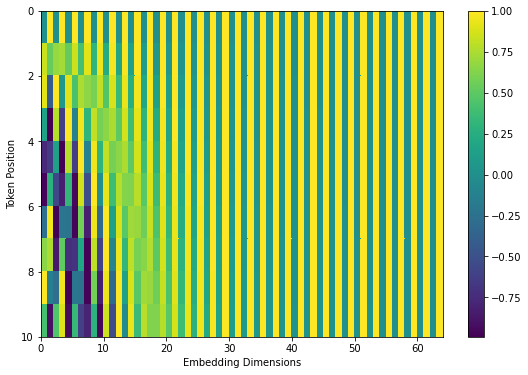

In [9]:
plt.figure(figsize=(9,6))
plt.pcolormesh(PosEncoder.pos_enc.numpy(), cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, dimensions))
plt.ylim((tokens,0))
plt.ylabel('Token Position')
plt.colorbar()

In [10]:
PAD=0

In [11]:
def PadMask(seq_q,seq_k,PAD):
    b_size,len_q=seq_q.shape
    b_szie,len_k=seq_k.shape
    mask=seq_k.eq(PAD).unseqeeze(1)
    return mask.expand(b_size,len_q,len_k)

In [12]:
def SeqMask(seq):
    attn_shape=[seq.shape[0],seq.shape[1],seq.shape[1]]
    mask=np.triu(np.ones(attn_shape),k=1)
    return torch.from_numpy(mask).byte()

In [13]:
class EncoderLayer(nn.Module):
    def __init__(self,num_head=8,d_k=64,d_v=64,d_model=512,d_ff=2048,drop=0.1):
        super(EncoderLayer,self).__init__()
        self.enc_MHA=MultiHeadAttention(num_head=num_head,d_k=d_k,d_v=d_v,d_model=d_model,drop=drop)
        self.FFN=FFN(d_model=d_model,d_ff=d_ff,drop=drop)
        self.resCon1=ResidualConnection(self.enc_MHA,d_model=d_model,drop=drop)
        self.resCon2=ResidualConnection(self.FFN,d_model=d_model,drop=drop)

    def forward(self,enc_input,mask):
        enc_output,attn=self.resCon1(enc_input,enc_input,enc_input,mask)
        enc_output=self.resCon2(enc_output)
        return enc_output,attn

In [14]:
class Encoder(nn.Module):
    def __init__(self,max_seq_len,src_vocab_size,num_layer,num_head,d_k,d_v,d_model,d_ff,drop,return_attn=False):
        super(Encoder,self).__init__()
        self.num_layer=num_layer
        self.return_attn=return_attn
        self.src_emb=nn.Embedding(src_vocab_size,d_model,padding_idx=PAD)
        self.layer_list=nn.ModuleList(
            [EncoderLayer(num_head,d_k,d_v,d_model,d_ff,drop) for _ in range(self.num_layer)]
        )

    def forward(self,enc_input):
        enc_pad_mask=PadMask(enc_input,enc_input)
        attns=[]
        for layer in self.layer_list:
            enc_output,attn=layer(enc_input,mask,enc_pad_mask)
            if self.return_attn:
                attns.append(attn)
        return enc_output,attns

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self,num_head=8,d_k=64,d_v=64,d_model=512,d_ff=2048,drop=0.1):
        super(DecoderLayer,self).__init__()
        self.dec_MHA=MultiHeadAttention(num_head=num_head,d_k=d_k,d_v=d_v,d_model=d_model,drop=drop)
        self.enc_dec_MHA=MultiHeadAttention(num_head=num_head,d_k=d_k,d_v=d_v,d_model=d_model,drop=drop)
        self.FFN=FFN(d_model=d_model,d_ff=d_ff,drop=drop)
        self.resCon1=ResidualConnection(self.dec_MHA,d_model=d_model,drop=drop)
        self.resCon2=ResidualConnection(self.enc_dec_MHA,d_model=d_model,drop=drop)
        self.resCon3=ResidualConnection(self.FFN,d_model=d_model,drop=drop)

    def forward(self,enc_output,dec_input,mask):
        dec_output,dec_attn=self.resCon1(dec_input,dec_input,dec_input,mask)
        dec_output,dec_enc_attn=self.resCon2(dec_input,enc_output,enc_output,mask)
        dec_output=self.resCon3(dec_output)
        return dec_output,dec_attn,dec_enc_attn

In [19]:
torch.triu(torch.ones(2,3,3),diagonal=1)

tensor([[[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 0.]],

        [[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 0.]]])

In [3]:
x=np.arange(10)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4]:
x[:-1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])